In [23]:
from skimage import metrics
from skimage.filters import threshold_otsu
from skimage.feature import blob_log, blob_dog
import torch
import numpy as np
import os
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from generative_ai.src.dataloader import DendritePFMDataset
from scipy import ndimage as ndi
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.rcParams["image.cmap"] = "coolwarm"

def fractal_dimension_boxcount(img, threshold=None, n_scales=8, min_box_size=2):
    if img.ndim == 3:
        img = img.mean(axis=-1)
    img = img.astype(float)
    if threshold is None:
        threshold = threshold_otsu(img)
    Z = img > threshold
    p = min(Z.shape)
    max_box_size = max(min_box_size + 1, p // 2)
    sizes = np.logspace(np.log10(min_box_size), np.log10(max_box_size),
                        num=n_scales, dtype=int)
    sizes = np.unique(sizes)
    counts = []
    for size in sizes:
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], size), axis=0),
            np.arange(0, Z.shape[1], size), axis=1)
        counts.append(np.count_nonzero(S))
    counts = np.array(counts)
    valid = counts > 0
    sizes = sizes[valid]
    counts = counts[valid]
    if len(sizes) < 2:
        return np.nan, sizes, counts
    log_inv_eps = np.log(1.0 / sizes.astype(float))
    log_N = np.log(counts.astype(float))
    coeffs = np.polyfit(log_inv_eps, log_N, 1)
    return coeffs[0], sizes, counts

def shape_index(img):
    gy, gx = np.gradient(img)
    gyy, gyx = np.gradient(gy)
    gxy, gxx = np.gradient(gx)
    H = (gxx + gyy) / 2.0
    K = gxx * gyy - gxy * gyx
    eta = np.arctan2(H, np.sqrt(np.abs(H**2 - K))) / np.pi + 0.5
    return eta

def annotate_box(ax, text, loc=(0.01, 0.99), fontsize=10):
    ax.text(loc[0], loc[1], text,
            transform=ax.transAxes,
            fontsize=fontsize,
            va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dataset = DendritePFMDataset(
    (3, 64, 64),
    os.path.join("data", "dataset_split.json"),
    split="test"
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=True
)

vae = torch.load(os.path.join(
    "results/V4_latent_size=4_noise0.1_kl0.01_grad1.0_20251121_021434",
    "ckpt", "CVAE.ckpt"
)).to(device)
vae.eval()

C:\Users\u0178651a\AppData\Local\Temp\ipykernel_26044\1964226529.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae = torch.load(os.path.join(


VAE(
  (encoder): ResEncoder(
    (layers): Sequential(
      (0): MultiKernelResBlock(
        (conv3): Conv2d(3, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (conv5): Conv2d(3, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (conv7): Conv2d(3, 512, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (shortcut): Sequential(
          (0): Conv2d(3, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): MultiKernelResBlock(
        (conv3): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (conv5): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (conv7): Conv2d(512, 1024, kernel_size

In [25]:
rmses = []
ssims = []
dfs_gt = []
dfs_pd = []
all_ids = []

with torch.no_grad():
    for i, (x, y, did, xo) in enumerate(test_dataloader):
        x = x.to(device)
        y = y.to(device)
        # recon_x = vae.inference(y)
        recon_x = vae(x, y)[0]
        x_np = x.detach().cpu().numpy()[0]
        r_np = recon_x.detach().cpu().numpy()[0]

        rmse = metrics.normalized_root_mse(
            x_np.transpose(1, 2, 0),
            r_np.transpose(1, 2, 0)
        )
        ssim = metrics.structural_similarity(
            x_np.transpose(1, 2, 0),
            r_np.transpose(1, 2, 0),
            win_size=3,
            data_range=(x_np.max() - x_np.min())
        )
        rmses.append(rmse)
        ssims.append(ssim)

        img_gt = x_np[0, :, :]
        img_pd = r_np[0, :, :]
        Df_gt, _, _ = fractal_dimension_boxcount(img_gt)
        Df_pd, _, _ = fractal_dimension_boxcount(img_pd)
        dfs_gt.append(Df_gt)
        dfs_pd.append(Df_pd)

        all_ids.append(did[0] if isinstance(did[0], str) else str(did[0]))

rmses = np.array(rmses)
ssims = np.array(ssims)
dfs_gt = np.array(dfs_gt)
dfs_pd = np.array(dfs_pd)

print(f"Test set size: {len(test_dataset)} samples")
print(f"Metrics computed for {len(rmses)} samples.")

Test set size: 450 samples
Metrics computed for 450 samples.


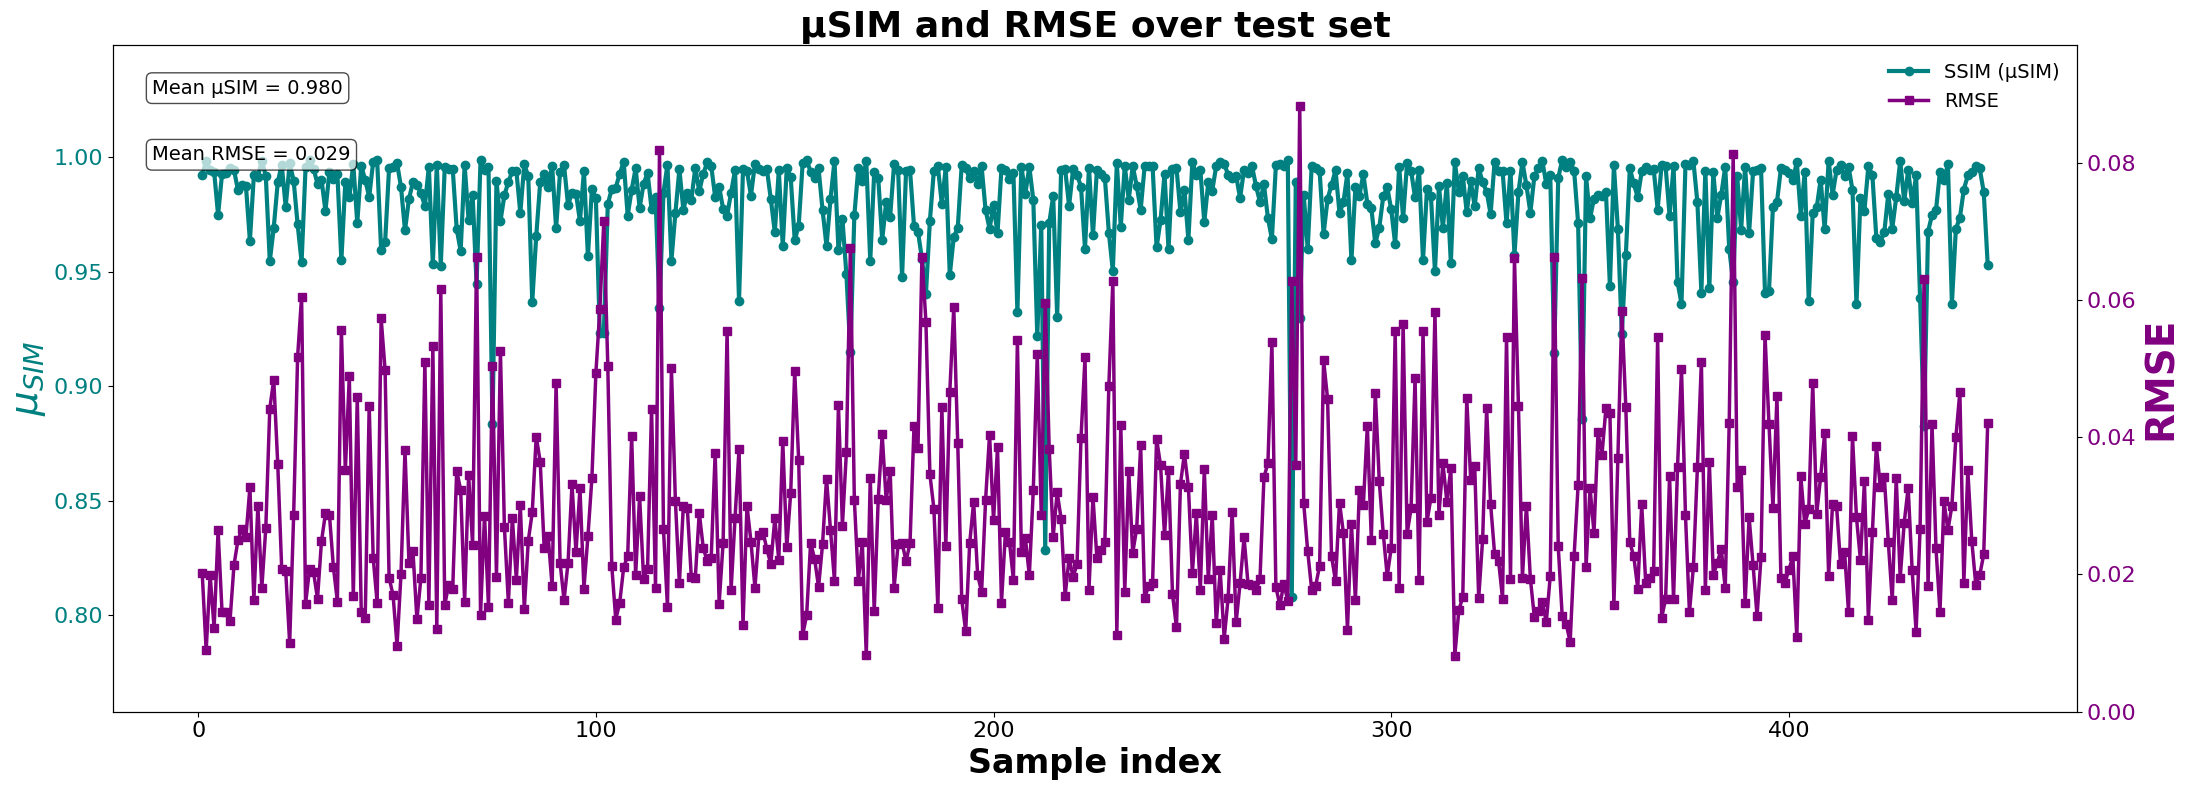

In [26]:
plt.rcParams["figure.figsize"] = (22, 8)

x_idx = np.arange(1, len(ssims) + 1)
ssim_avg = np.nanmean(ssims)
rmse_avg = np.nanmean(rmses)

fig, ax1 = plt.subplots()

ax1.plot(x_idx, ssims, '-o', color='teal', linewidth=3, markersize=6,
         label=f'SSIM (μSIM)')
ax1.set_xlabel("Sample index", size=24, weight='bold')
ax1.set_ylabel(r"$\mu_{SIM}$", size=28, color='teal', weight='bold')
ax1.tick_params(axis='y', labelcolor='teal', labelsize=16)
ax1.tick_params(axis='x', labelcolor='black', labelsize=16)
ax1.set_ylim([max(0.0, ssims.min() - 0.05), min(1.05, ssims.max() + 0.05)])

annotate_box(ax1, f"Mean μSIM = {ssim_avg:.3f}", loc=(0.02, 0.95), fontsize=14)

ax2 = ax1.twinx()
ax2.plot(x_idx, rmses, '-s', color='purple', linewidth=2.5, markersize=6,
         label=f'RMSE')
ax2.set_ylabel("RMSE", size=28, color='purple', weight='bold')
ax2.tick_params(axis='y', labelcolor='purple', labelsize=16)
ax2.set_ylim([0, rmses.max() * 1.1])

annotate_box(ax2, f"Mean RMSE = {rmse_avg:.3f}", loc=(0.02, 0.85), fontsize=14)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
           loc='upper right', fontsize=14, frameon=False)

plt.title("μSIM and RMSE over test set", fontsize=26, weight='bold')
plt.tight_layout()
plt.show()

Fractal Dimension GT   : mean = 1.621 ± 0.231
Fractal Dimension Pred : mean = 1.611 ± 0.258
ΔD_f (Pred - GT)       : mean = -0.0103 ± 0.0756
|ΔD_f|                 : mean = 0.0462 ± 0.0606


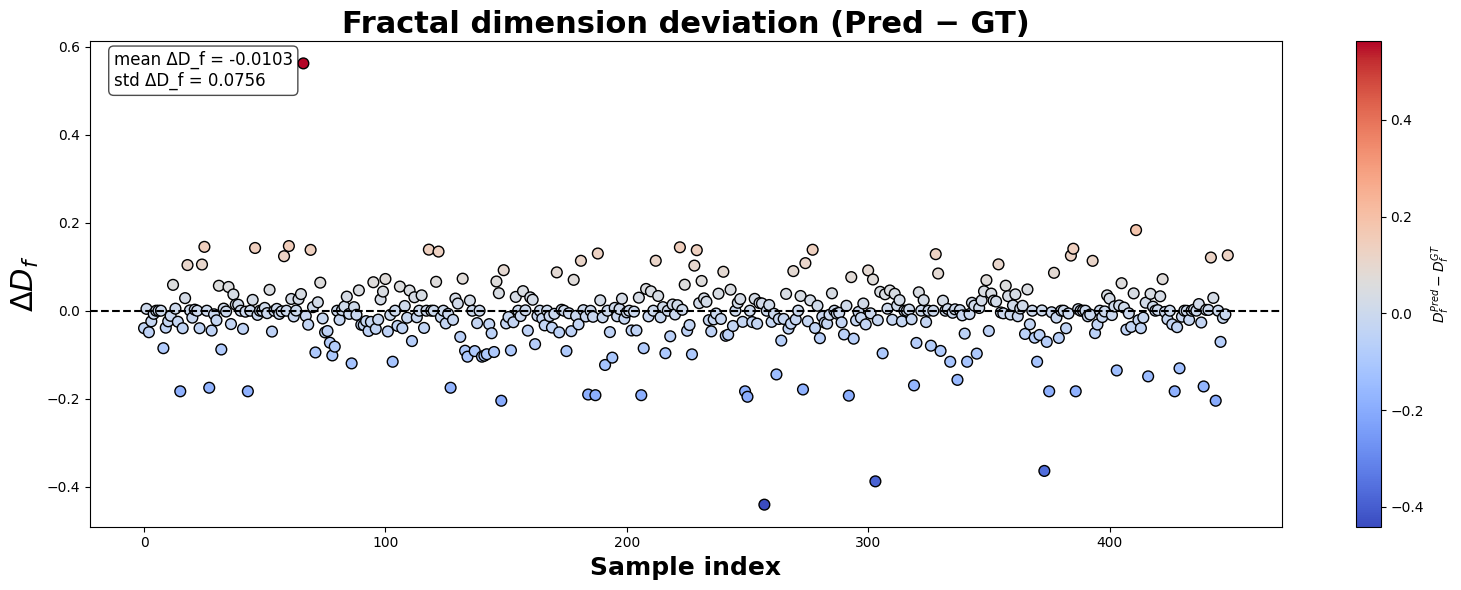

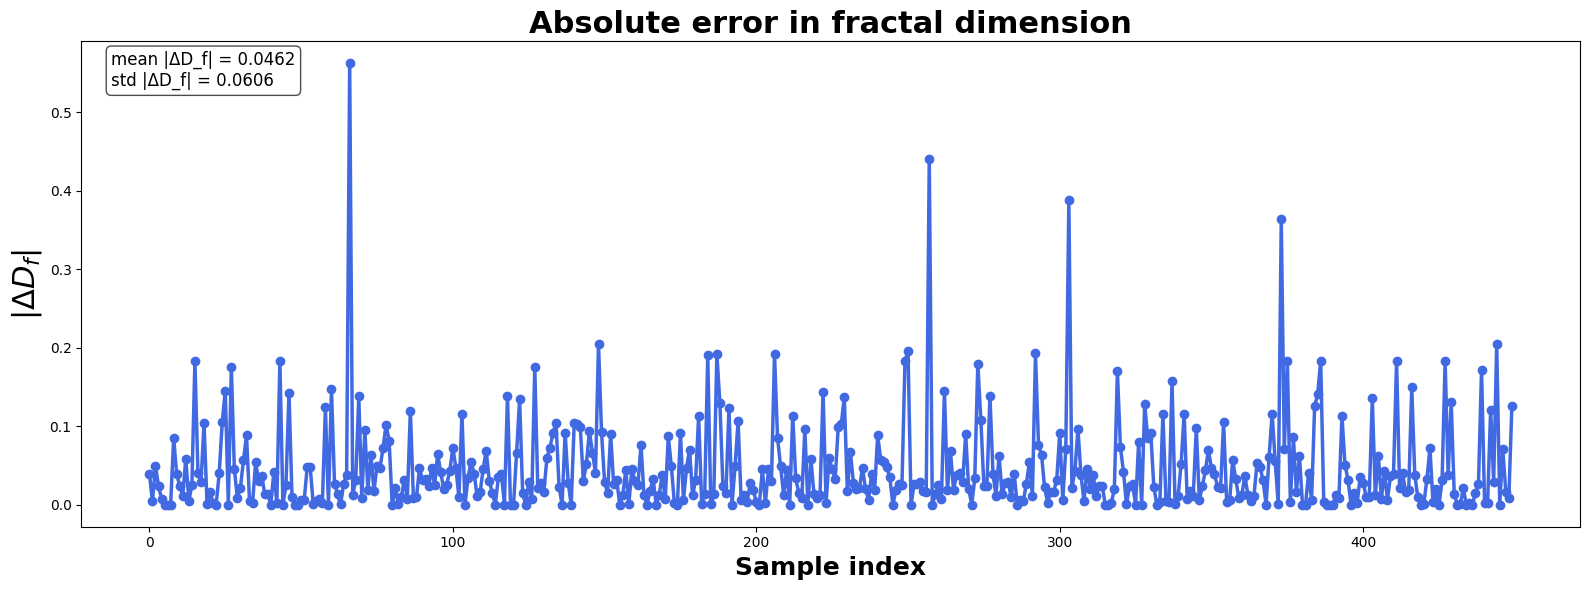

In [27]:
df_diff = dfs_pd - dfs_gt
df_abs = np.abs(df_diff)

Df_gt_mean = np.nanmean(dfs_gt)
Df_pd_mean = np.nanmean(dfs_pd)
Df_gt_std = np.nanstd(dfs_gt)
Df_pd_std = np.nanstd(dfs_pd)
Df_diff_mean = np.nanmean(df_diff)
Df_diff_std = np.nanstd(df_diff)
Df_abs_mean = np.nanmean(df_abs)
Df_abs_std = np.nanstd(df_abs)

print(f"Fractal Dimension GT   : mean = {Df_gt_mean:.3f} ± {Df_gt_std:.3f}")
print(f"Fractal Dimension Pred : mean = {Df_pd_mean:.3f} ± {Df_pd_std:.3f}")
print(f"ΔD_f (Pred - GT)       : mean = {Df_diff_mean:.4f} ± {Df_diff_std:.4f}")
print(f"|ΔD_f|                 : mean = {Df_abs_mean:.4f} ± {Df_abs_std:.4f}")

plt.figure(figsize=(16, 6))
sc = plt.scatter(np.arange(len(df_diff)), df_diff,
                 c=df_diff, cmap='coolwarm', s=60, edgecolors='k')
plt.axhline(0.0, color='black', linewidth=1.5, linestyle='--')
plt.colorbar(sc, label=r"$D_f^{Pred} - D_f^{GT}$")

plt.xlabel("Sample index", fontsize=18, weight="bold")
plt.ylabel(r"$\Delta D_f$", fontsize=22, weight="bold")
plt.title("Fractal dimension deviation (Pred − GT)", fontsize=22, weight="bold")

annotate_box(plt.gca(),
             f"mean ΔD_f = {Df_diff_mean:.4f}\nstd ΔD_f = {Df_diff_std:.4f}",
             loc=(0.02, 0.98), fontsize=12)

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(df_abs, '-o', color='royalblue', linewidth=2.5, markersize=6)
plt.xlabel("Sample index", fontsize=18, weight="bold")
plt.ylabel(r"$|\Delta D_f|$", fontsize=22, weight="bold")
plt.title("Absolute error in fractal dimension", fontsize=22, weight="bold")

annotate_box(plt.gca(),
             f"mean |ΔD_f| = {Df_abs_mean:.4f}\nstd |ΔD_f| = {Df_abs_std:.4f}",
             loc=(0.02, 0.98), fontsize=12)

plt.tight_layout()
plt.show()

In [28]:
num_vis = 5
# np.random.seed(0)
indices_vis = np.random.choice(len(test_dataset), size=num_vis, replace=False)
print("Randomly selected indices for visualization:", indices_vis)

Randomly selected indices for visualization: [265 368 324   8 383]


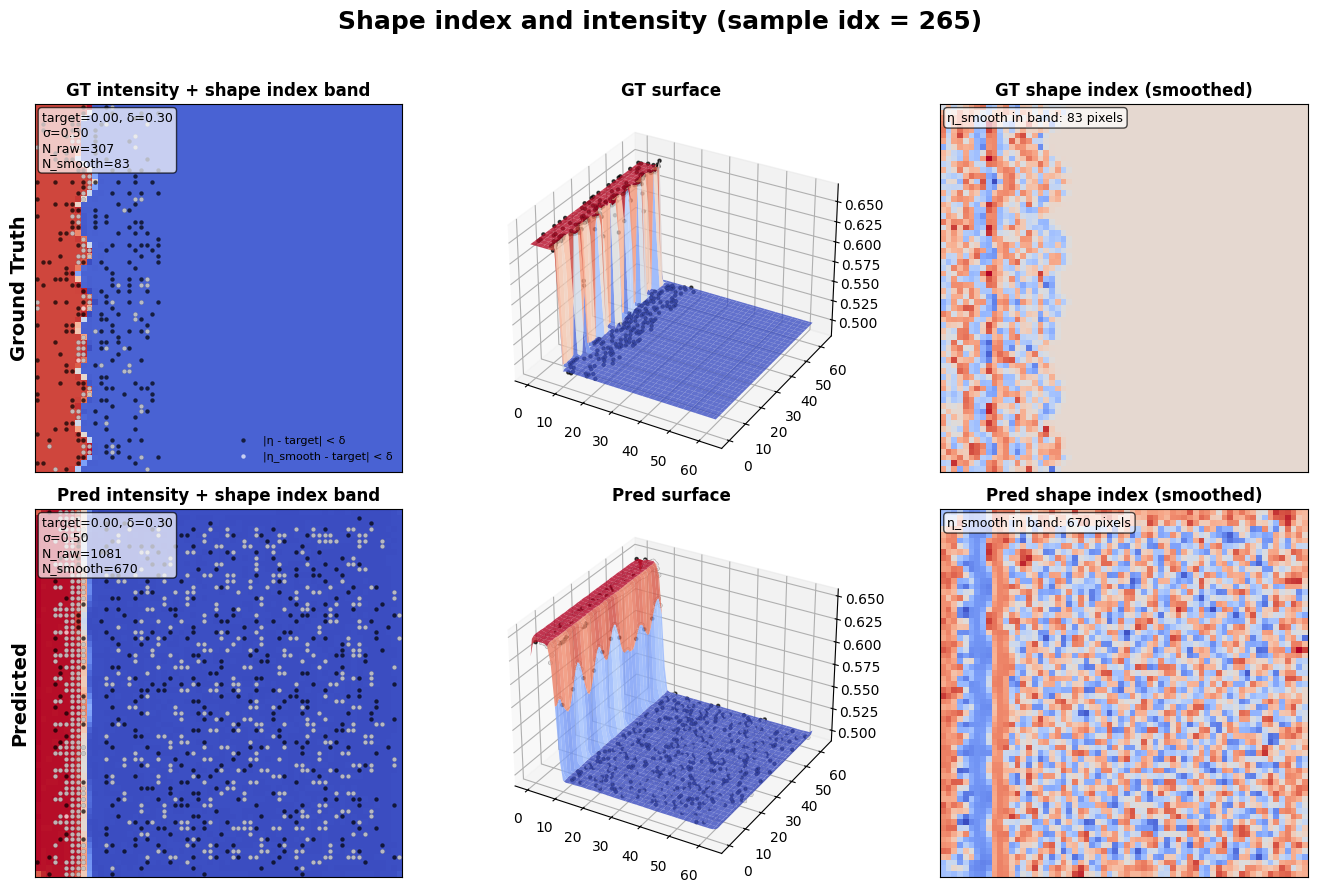

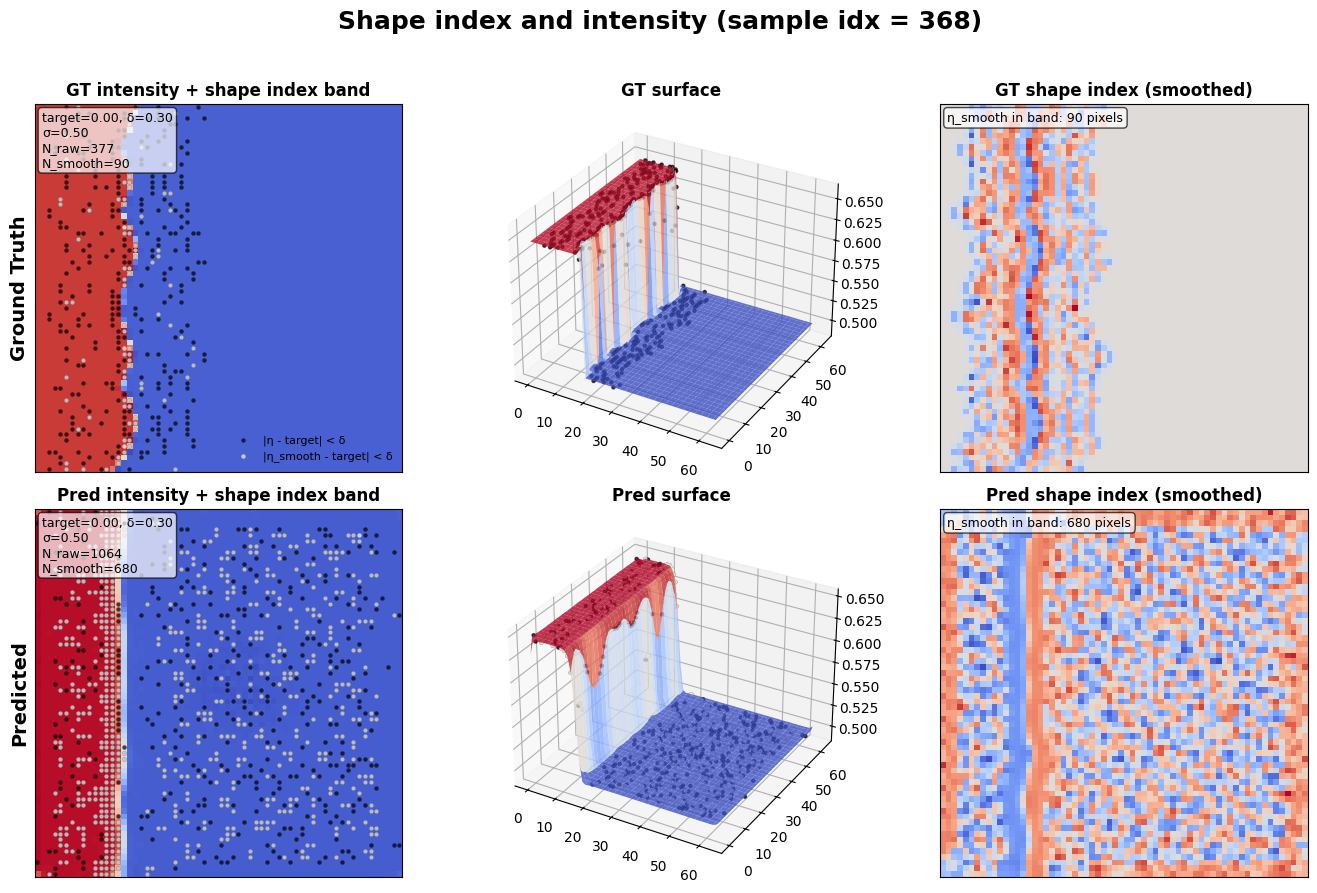

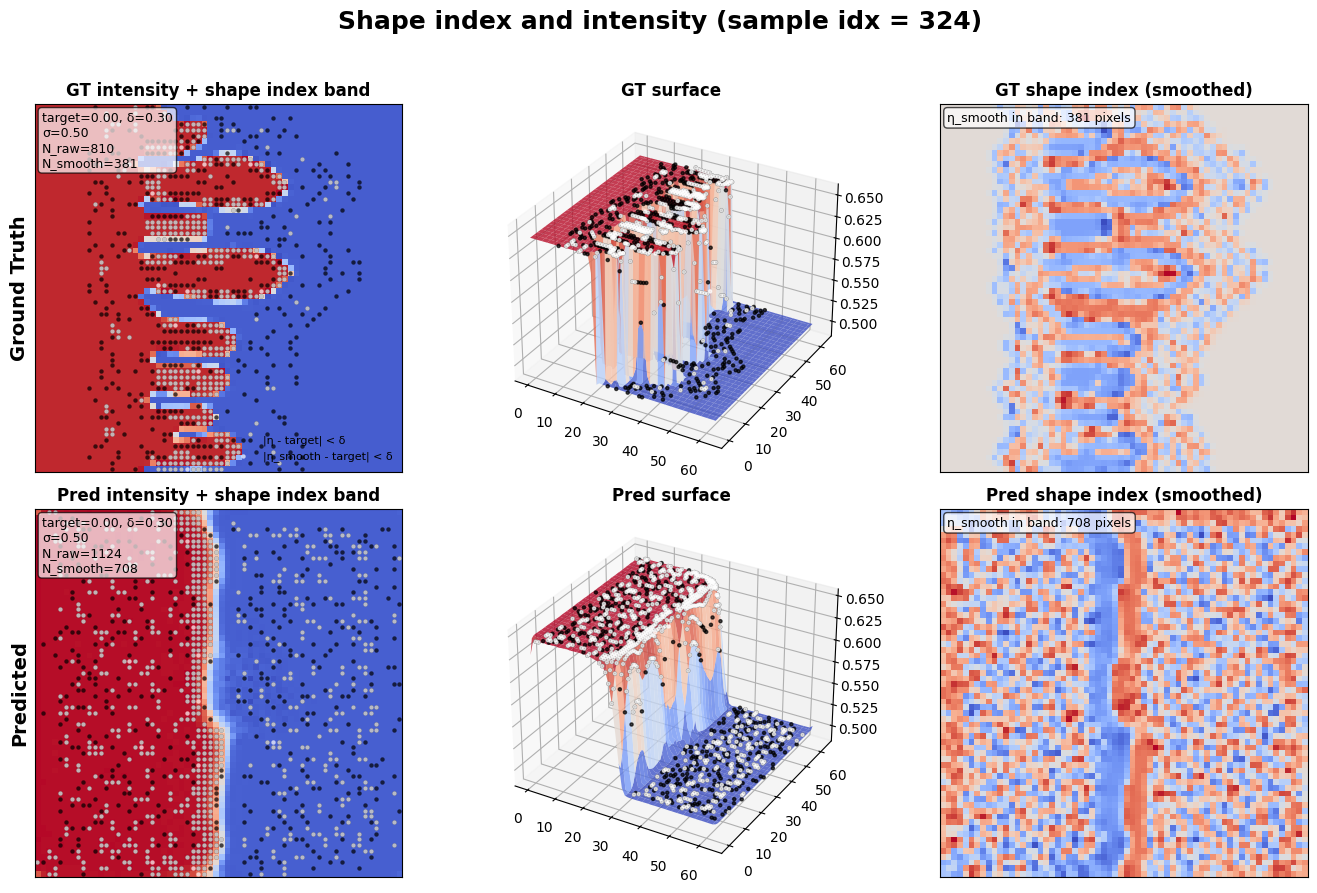

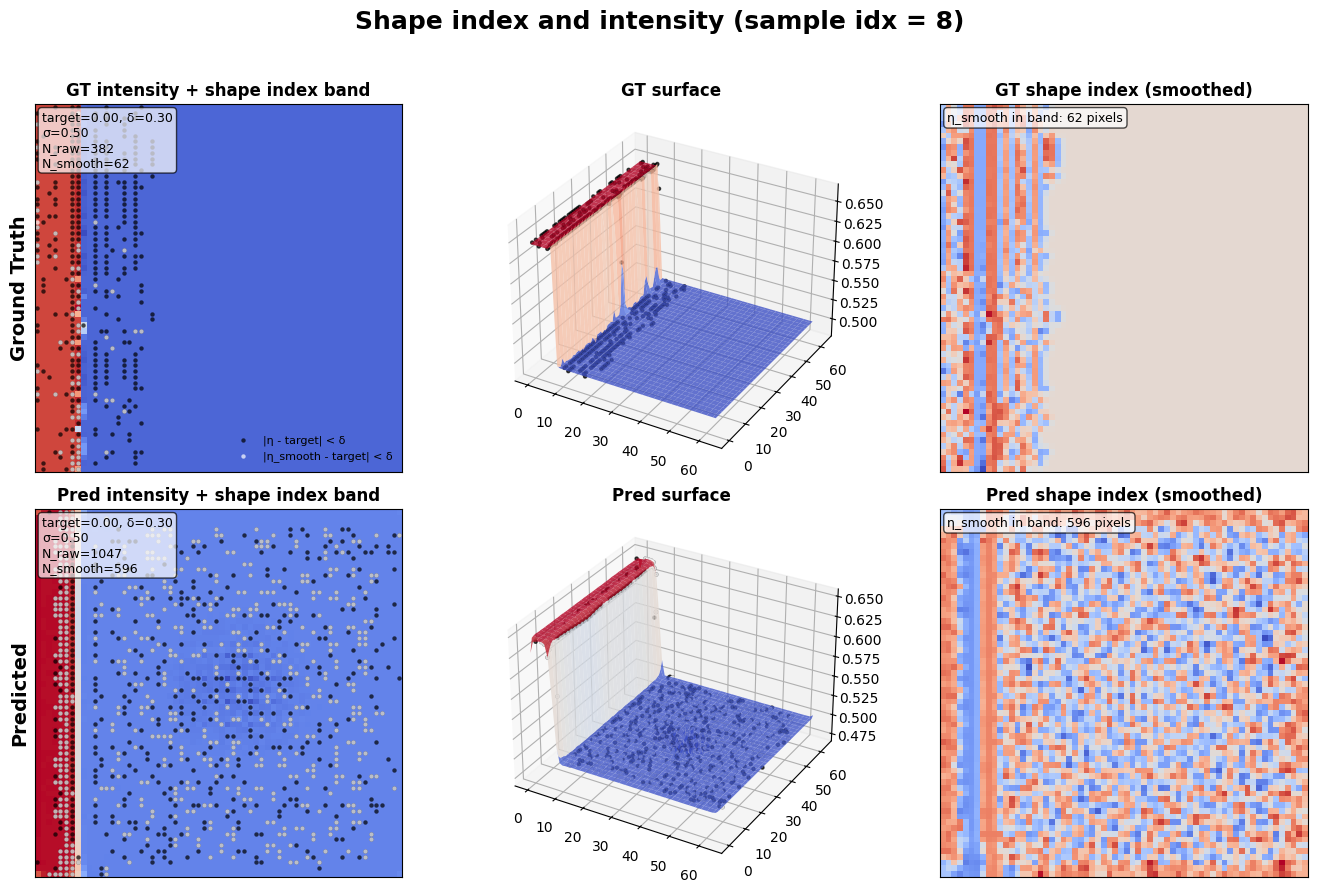

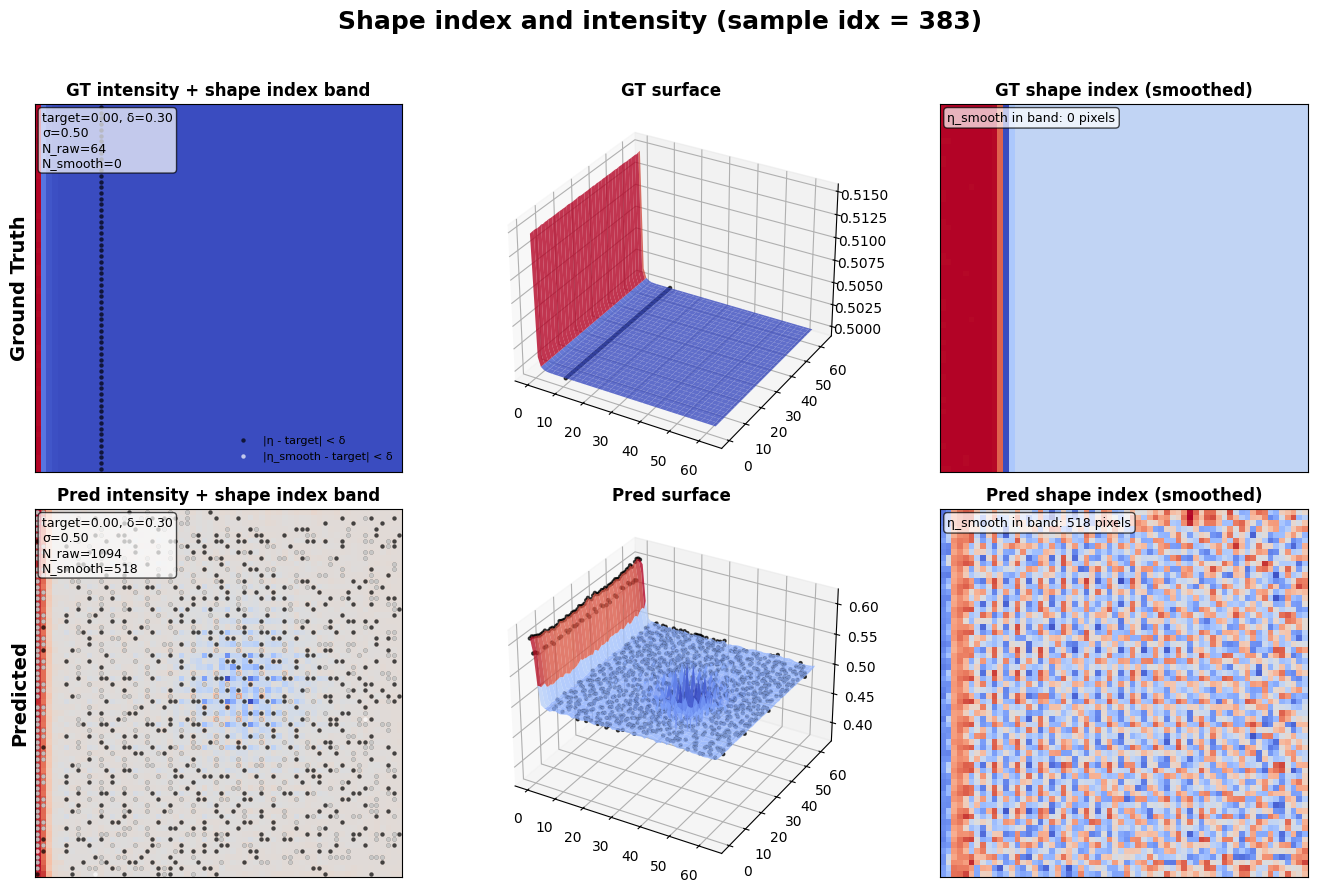

In [29]:
target = 0.0
delta = 0.3
sigma = 0.5

for s_i, idx in enumerate(indices_vis):
    x_s, y_s, did_s, xo_s = test_dataset[idx]
    x_s = x_s.unsqueeze(0).to(device)
    y_s = y_s.unsqueeze(0).to(device)

    with torch.no_grad():
        recon_s = vae(x_s, y_s)[0]

    gt_img = x_s[0, 0].detach().cpu().numpy()
    pd_img = recon_s[0, 0].detach().cpu().numpy()

    s_gt = shape_index(gt_img)
    s_pd = shape_index(pd_img)
    s_gt_smooth = ndi.gaussian_filter(s_gt, sigma=sigma)
    s_pd_smooth = ndi.gaussian_filter(s_pd, sigma=sigma)

    mask_gt = np.abs(s_gt - target) < delta
    mask_gt_s = np.abs(s_gt_smooth - target) < delta
    mask_pd = np.abs(s_pd - target) < delta
    mask_pd_s = np.abs(s_pd_smooth - target) < delta

    py_gt, px_gt = np.where(mask_gt)
    py_gt_s, px_gt_s = np.where(mask_gt_s)
    py_pd, px_pd = np.where(mask_pd)
    py_pd_s, px_pd_s = np.where(mask_pd_s)

    pz_gt = gt_img[py_gt, px_gt]
    pz_gt_s = gt_img[py_gt_s, px_gt_s]
    pz_pd = pd_img[py_pd, px_pd]
    pz_pd_s = pd_img[py_pd_s, px_pd_s]

    fig = plt.figure(figsize=(14, 9))
    plt.suptitle(f"Shape index and intensity (sample idx = {idx})",
                 fontsize=18, weight='bold')

    scatter_kw = dict(s=10, alpha=0.7, linewidths=0)

    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(gt_img, cmap='coolwarm')
    ax1.scatter(px_gt, py_gt, color='black', **scatter_kw, label='|η - target| < δ')
    ax1.scatter(px_gt_s, py_gt_s, color='white', **scatter_kw, label='|η_smooth - target| < δ')
    ax1.set_title("GT intensity + shape index band", fontsize=12, weight='bold')
    ax1.set_ylabel("Ground Truth", fontsize=14, weight='bold')
    ax1.set_xticks([]); ax1.set_yticks([])

    annotate_box(ax1,
                 f"target={target:.2f}, δ={delta:.2f}\nσ={sigma:.2f}\nN_raw={mask_gt.sum()}\nN_smooth={mask_gt_s.sum()}",
                 loc=(0.02, 0.98), fontsize=9)
    ax1.legend(loc='lower right', fontsize=8, frameon=False)

    ax2 = fig.add_subplot(2, 3, 2, projection='3d')
    Xg, Yg = np.meshgrid(np.arange(gt_img.shape[1]), np.arange(gt_img.shape[0]))
    ax2.plot_surface(Xg, Yg, gt_img, cmap='coolwarm', alpha=0.8, linewidth=0)
    ax2.scatter(px_gt, py_gt, pz_gt, color='black', s=5, alpha=0.7)
    ax2.scatter(px_gt_s, py_gt_s, pz_gt_s, color='white', s=5, alpha=0.7)
    ax2.set_title("GT surface", fontsize=12, weight='bold')

    ax3 = fig.add_subplot(2, 3, 3)
    ax3.imshow(s_gt_smooth, cmap='coolwarm')
    ax3.set_title("GT shape index (smoothed)", fontsize=12, weight='bold')
    ax3.set_xticks([]); ax3.set_yticks([])
    annotate_box(ax3,
                 f"η_smooth in band: {mask_gt_s.sum()} pixels",
                 loc=(0.02, 0.98), fontsize=9)

    ax4 = fig.add_subplot(2, 3, 4)
    ax4.imshow(pd_img, cmap='coolwarm')
    ax4.scatter(px_pd, py_pd, color='black', **scatter_kw)
    ax4.scatter(px_pd_s, py_pd_s, color='white', **scatter_kw)
    ax4.set_title("Pred intensity + shape index band", fontsize=12, weight='bold')
    ax4.set_ylabel("Predicted", fontsize=14, weight='bold')
    ax4.set_xticks([]); ax4.set_yticks([])

    annotate_box(ax4,
                 f"target={target:.2f}, δ={delta:.2f}\nσ={sigma:.2f}\nN_raw={mask_pd.sum()}\nN_smooth={mask_pd_s.sum()}",
                 loc=(0.02, 0.98), fontsize=9)

    ax5 = fig.add_subplot(2, 3, 5, projection='3d')
    Xp, Yp = np.meshgrid(np.arange(pd_img.shape[1]), np.arange(pd_img.shape[0]))
    ax5.plot_surface(Xp, Yp, pd_img, cmap='coolwarm', alpha=0.8, linewidth=0)
    ax5.scatter(px_pd, py_pd, pz_pd, color='black', s=5, alpha=0.7)
    ax5.scatter(px_pd_s, py_pd_s, pz_pd_s, color='white', s=5, alpha=0.7)
    ax5.set_title("Pred surface", fontsize=12, weight='bold')

    ax6 = fig.add_subplot(2, 3, 6)
    ax6.imshow(s_pd_smooth, cmap='coolwarm')
    ax6.set_title("Pred shape index (smoothed)", fontsize=12, weight='bold')
    ax6.set_xticks([]); ax6.set_yticks([])
    annotate_box(ax6,
                 f"η_smooth in band: {mask_pd_s.sum()} pixels",
                 loc=(0.02, 0.98), fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

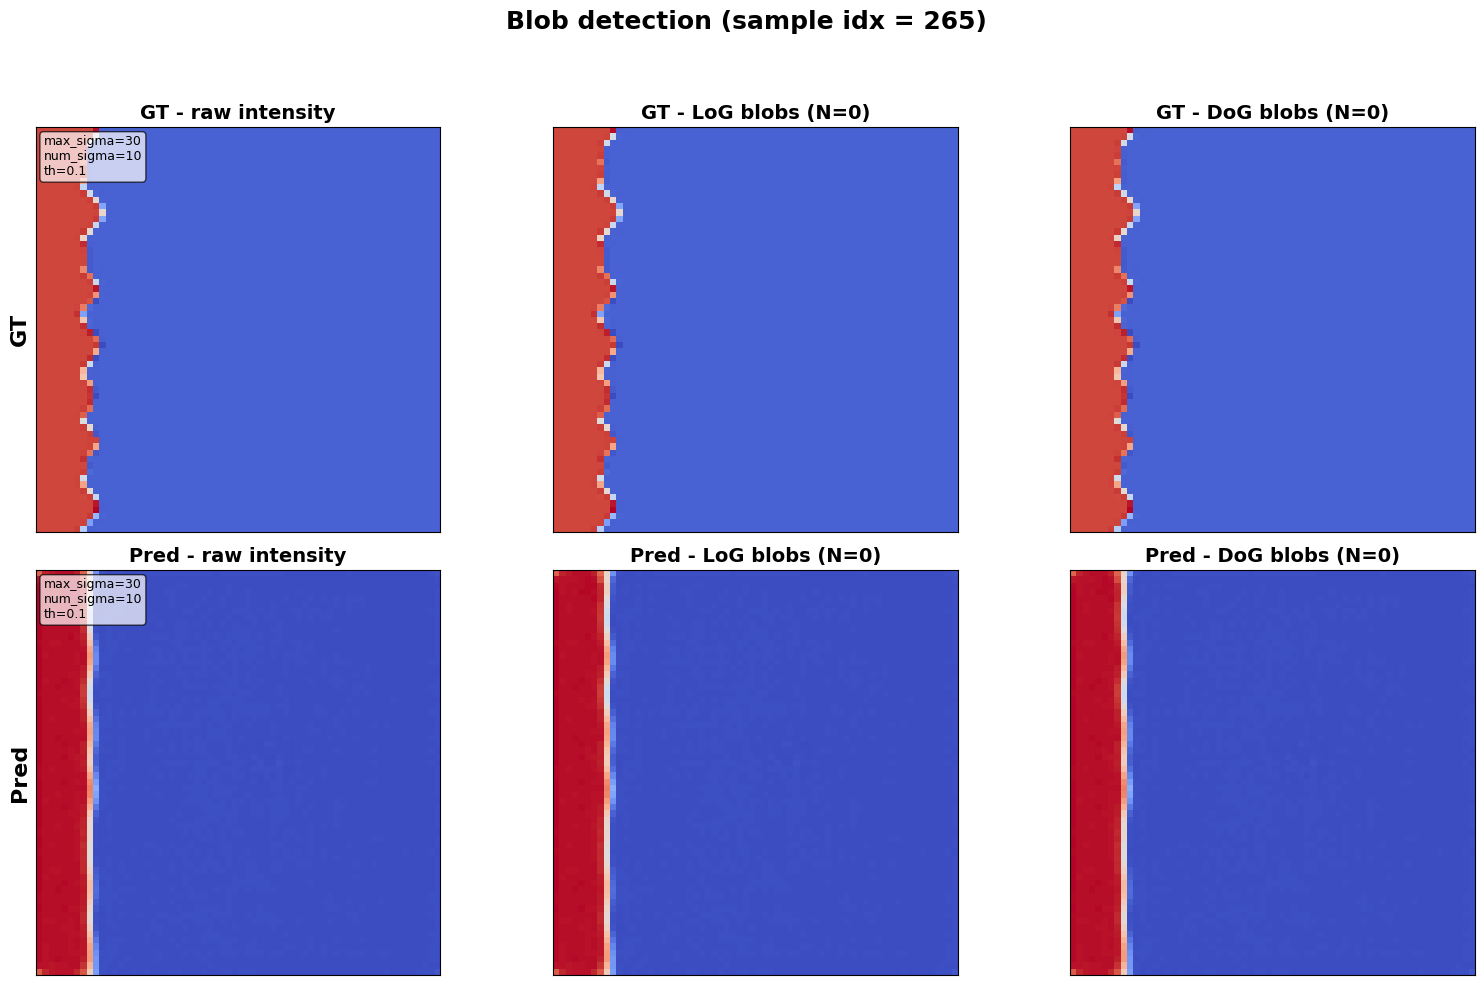

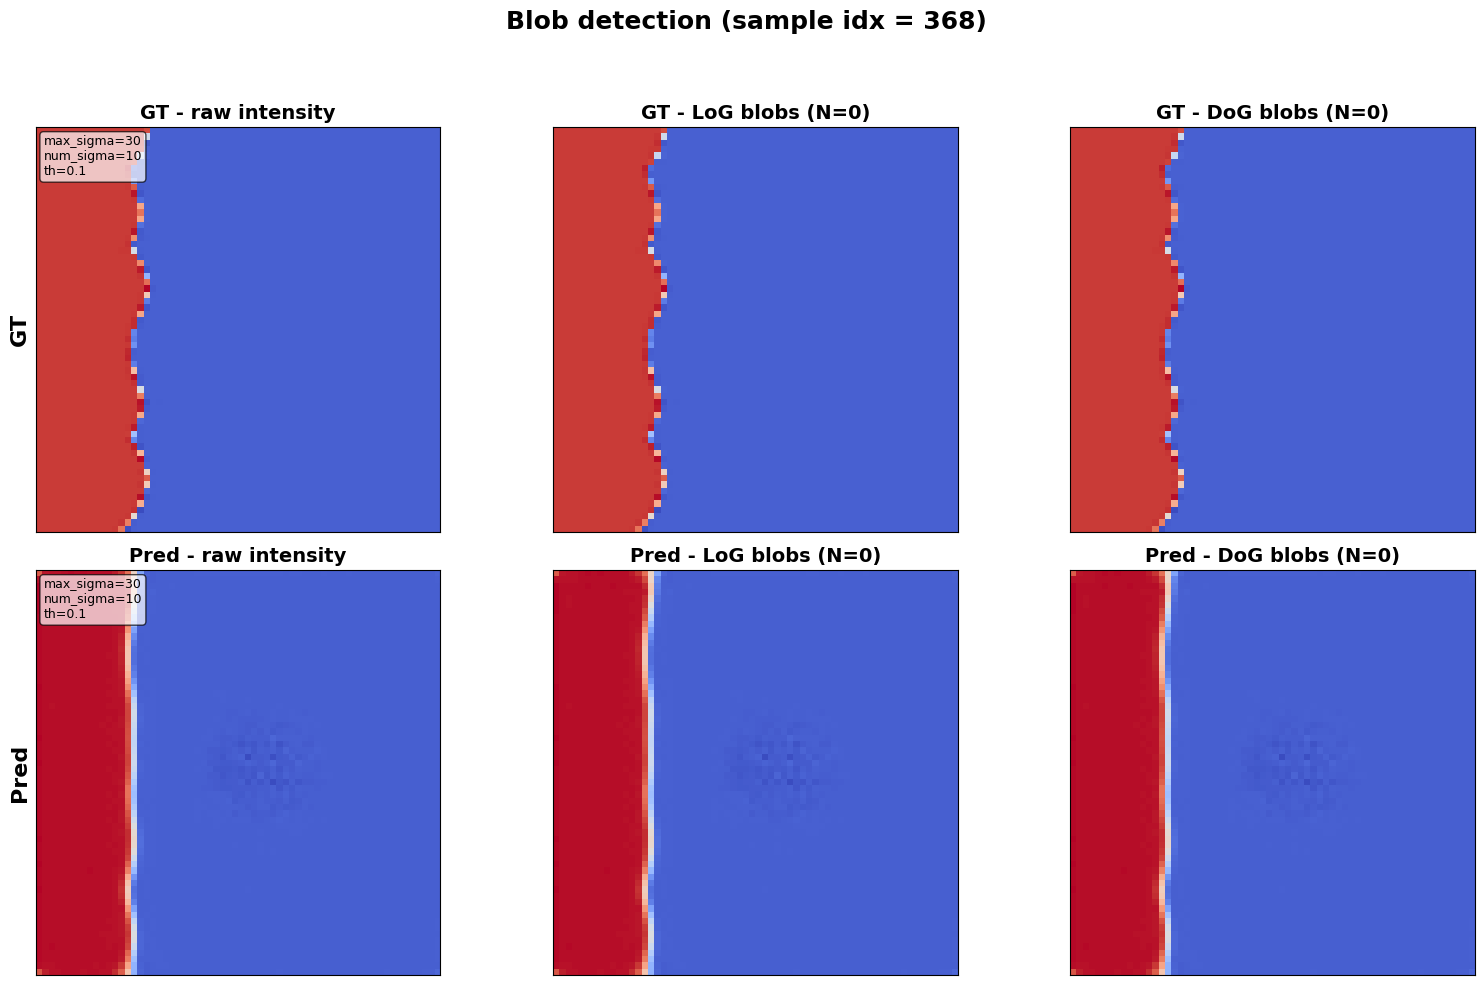

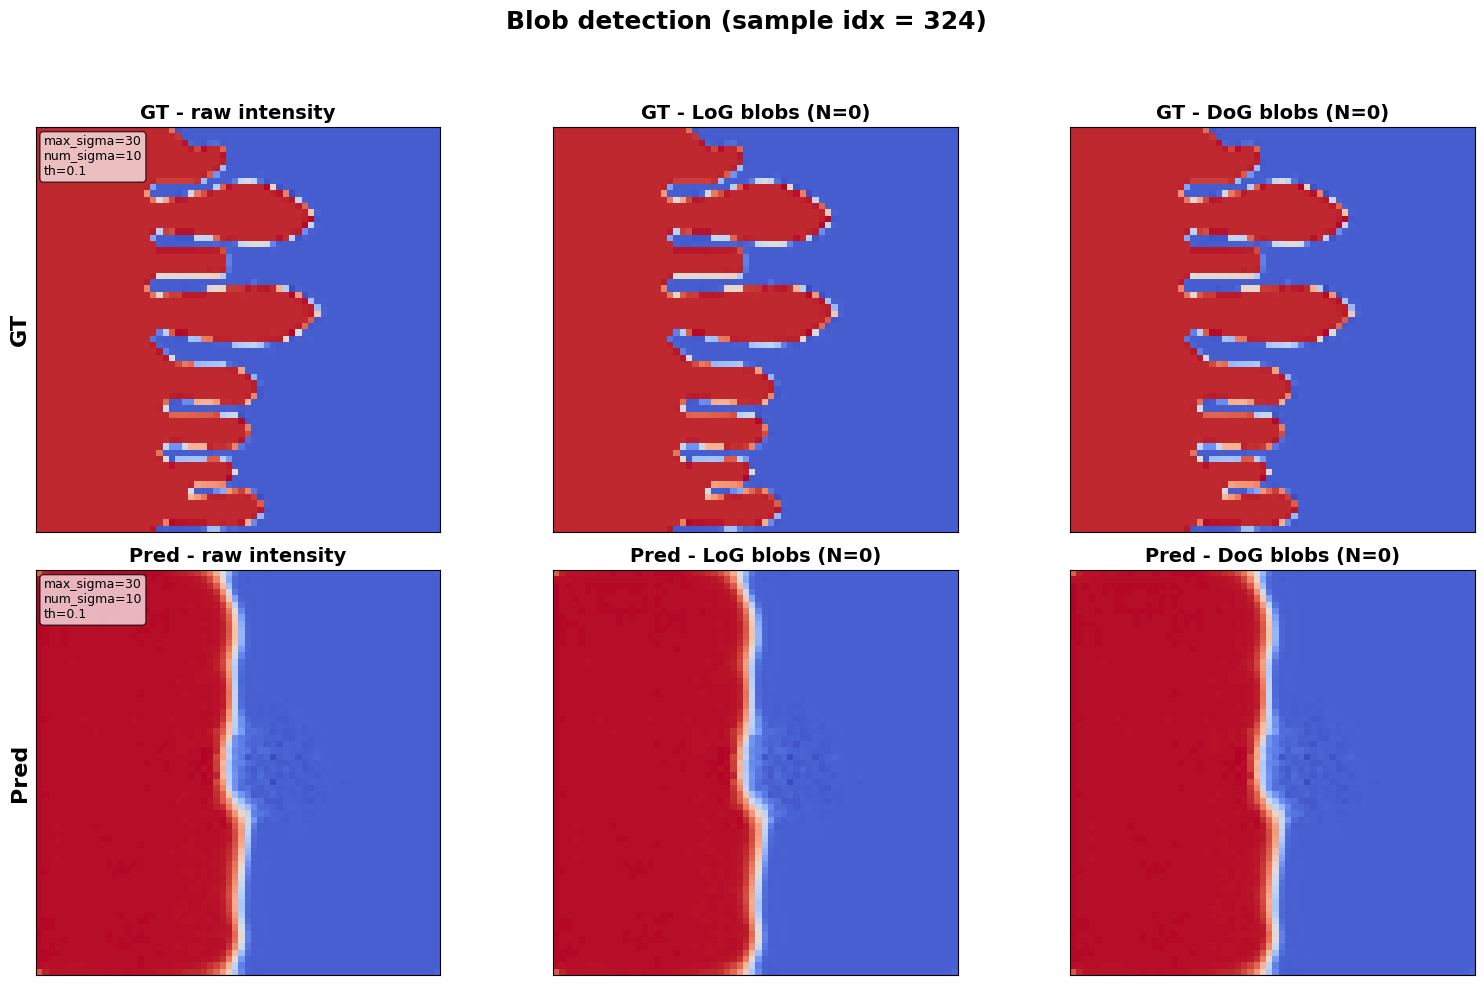

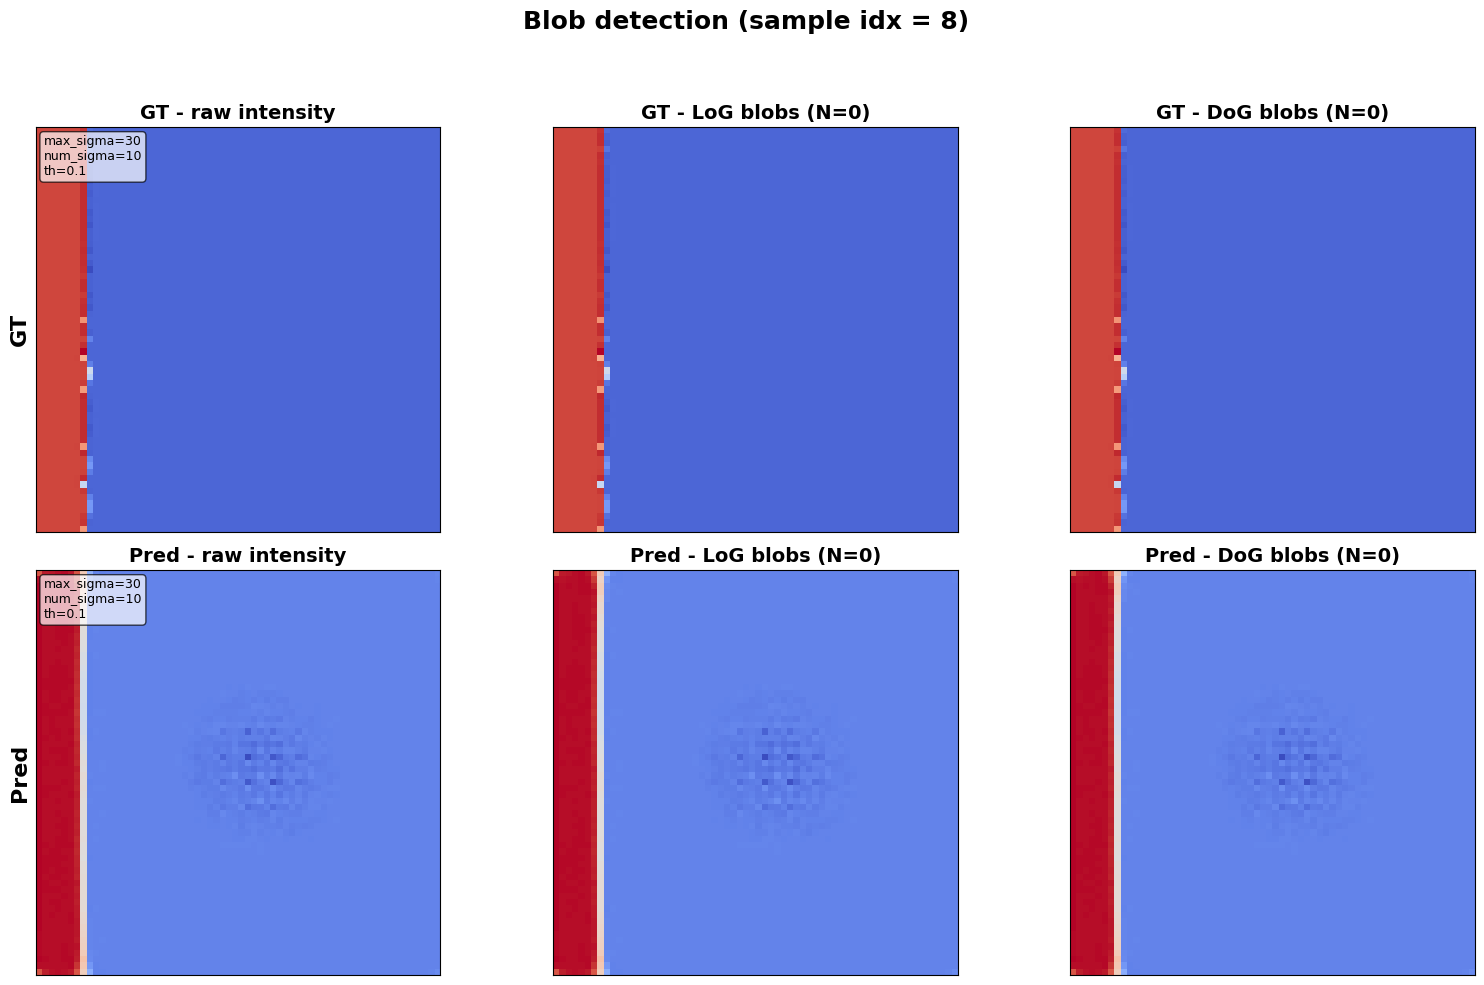

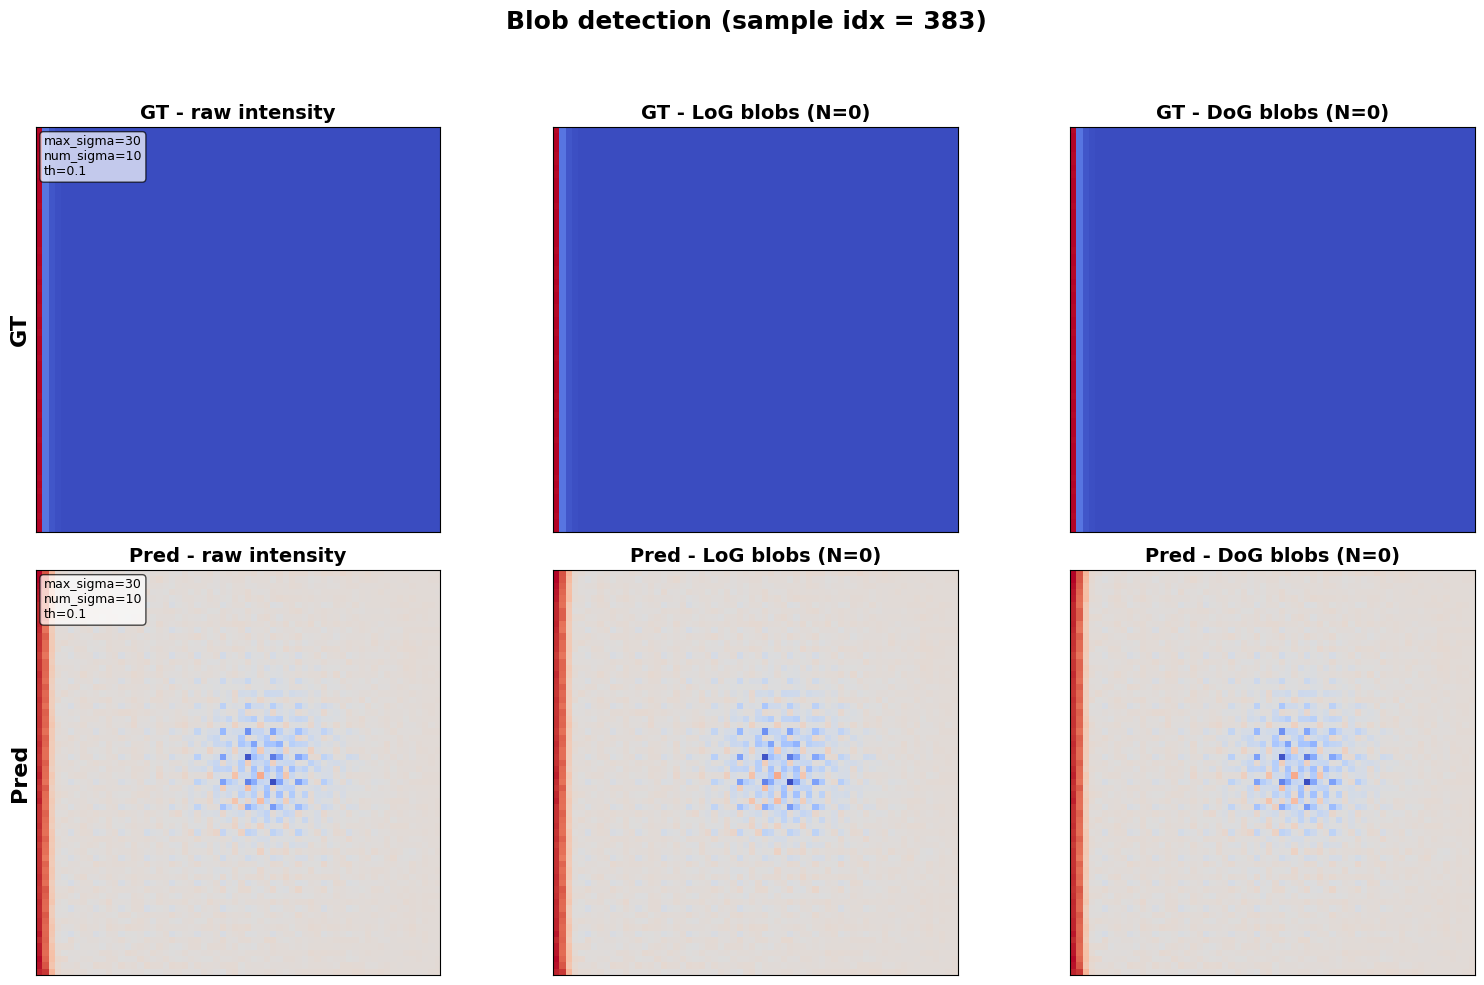

In [30]:
max_sigma = 30
num_sigma = 10
threshold = 0.1

for s_i, idx in enumerate(indices_vis):
    x_s, y_s, did_s, xo_s = test_dataset[idx]
    x_s = x_s.unsqueeze(0).to(device)
    y_s = y_s.unsqueeze(0).to(device)

    with torch.no_grad():
        recon_s = vae(x_s, y_s)[0]

    img_gt = x_s[0, 0].detach().cpu().numpy()
    img_pd = recon_s[0, 0].detach().cpu().numpy()

    log_gt = blob_log(img_gt, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)
    log_pd = blob_log(img_pd, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)
    dog_gt = blob_dog(img_gt, max_sigma=max_sigma, threshold=threshold)
    dog_pd = blob_dog(img_pd, max_sigma=max_sigma, threshold=threshold)

    log_gt[:, 2] *= sqrt(2)
    log_pd[:, 2] *= sqrt(2)
    dog_gt[:, 2] *= sqrt(2)
    dog_pd[:, 2] *= sqrt(2)

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    plt.suptitle(f"Blob detection (sample idx = {idx})", fontsize=18, weight='bold')

    ax1, ax2, ax3 = axes[0]
    ax4, ax5, ax6 = axes[1]

    ax1.imshow(img_gt, cmap='coolwarm')
    ax1.set_title("GT - raw intensity", fontsize=14, weight='bold')
    ax1.set_ylabel("GT", fontsize=16, weight='bold')
    ax1.set_xticks([]); ax1.set_yticks([])
    annotate_box(ax1,
                 f"max_sigma={max_sigma}\nnum_sigma={num_sigma}\nth={threshold}",
                 loc=(0.02, 0.98), fontsize=9)

    ax2.imshow(img_gt, cmap='coolwarm')
    ax2.set_title(f"GT - LoG blobs (N={len(log_gt)})", fontsize=14, weight='bold')
    ax2.set_xticks([]); ax2.set_yticks([])
    for y_c, x_c, r in log_gt:
        ax2.add_patch(plt.Circle((x_c, y_c), r, edgecolor='black', linewidth=1.5, fill=False))

    ax3.imshow(img_gt, cmap='coolwarm')
    ax3.set_title(f"GT - DoG blobs (N={len(dog_gt)})", fontsize=14, weight='bold')
    ax3.set_xticks([]); ax3.set_yticks([])
    for y_c, x_c, r in dog_gt:
        ax3.add_patch(plt.Circle((x_c, y_c), r, edgecolor='black', linewidth=1.5, fill=False))

    ax4.imshow(img_pd, cmap='coolwarm')
    ax4.set_title("Pred - raw intensity", fontsize=14, weight='bold')
    ax4.set_ylabel("Pred", fontsize=16, weight='bold')
    ax4.set_xticks([]); ax4.set_yticks([])
    annotate_box(ax4,
                 f"max_sigma={max_sigma}\nnum_sigma={num_sigma}\nth={threshold}",
                 loc=(0.02, 0.98), fontsize=9)

    ax5.imshow(img_pd, cmap='coolwarm')
    ax5.set_title(f"Pred - LoG blobs (N={len(log_pd)})", fontsize=14, weight='bold')
    ax5.set_xticks([]); ax5.set_yticks([])
    for y_c, x_c, r in log_pd:
        ax5.add_patch(plt.Circle((x_c, y_c), r, edgecolor='black', linewidth=1.5, fill=False))

    ax6.imshow(img_pd, cmap='coolwarm')
    ax6.set_title(f"Pred - DoG blobs (N={len(dog_pd)})", fontsize=14, weight='bold')
    ax6.set_xticks([]); ax6.set_yticks([])
    for y_c, x_c, r in dog_pd:
        ax6.add_patch(plt.Circle((x_c, y_c), r, edgecolor='black', linewidth=1.5, fill=False))

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()